In [ ]:
#-----------------------------------------
# Title:  Wine Data for Clustering (Principal Components Analysis, K-Means Clustering, and Hierarchical Clustering)
# Subtitle: DDS-8555, Assignment 7
# Author: Madgene Moise
# Date: Sunday, June 29, 2025
#-----------------------------------------

In [2]:
# Import the necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [4]:
# Load the dataset
df = pd.read_csv("/kaggle/input/wine-dataset-for-clustering/wine-clustering.csv")

In [5]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [6]:
# Check PCA assumptions:
# 1. Linearity - checked via correlation heatmap
correlation_matrix = pd.DataFrame(scaled_data, columns=df.columns).corr()

# 2. Sampling adequacy (KMO) and 3. Sphericity (Bartlett’s test)
# Skipping formal statistical tests due to lack of available implementation in sklearn;
# Will visually assess multicollinearity instead.

In [7]:
# Apply PCA
pca = PCA()
pca.fit(scaled_data)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

In [8]:
# Determine number of components to retain 80% variance
num_components_80_var = np.argmax(cumulative_variance >= 0.80) + 1

# Transform data using the selected components
pca_final = PCA(n_components=num_components_80_var)
pca_data = pca_final.fit_transform(scaled_data)

# Prepare outputs
pca_results = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance': cumulative_variance
})

In [12]:
# Display PCA results and cumulative variance
print(pca_results)


   Component  Explained Variance Ratio  Cumulative Variance
0        PC1                  0.361988             0.361988
1        PC2                  0.192075             0.554063
2        PC3                  0.111236             0.665300
3        PC4                  0.070690             0.735990
4        PC5                  0.065633             0.801623
5        PC6                  0.049358             0.850981
6        PC7                  0.042387             0.893368
7        PC8                  0.026807             0.920175
8        PC9                  0.022222             0.942397
9       PC10                  0.019300             0.961697
10      PC11                  0.017368             0.979066
11      PC12                  0.012982             0.992048
12      PC13                  0.007952             1.000000


**Principal Component Analysis (PCA) Results**

The PCA was applied to the standardized wine dataset. The first n = {num_components_80_var} principal components retain at least 80% of the total variance, meaning that these components represent a lower-dimensional approximation of the data that still captures the majority of its information content. 

**Assumptions of PCA**

* Linearity of the Variables: PCA assumes linear relationships among variables. A correlation matrix (sample shown below) helps assess this.

I observed:
  * Moderate to strong correlations, e.g., between Ash and Ash_Alcanity (0.443), and Alcohol and Magnesium (0.271).
  * These correlations suggest some redundancy and thus support PCA's usefulness for dimensionality reduction.
_____________________________
* No Significant Outliers: Further along in this analysis, I will perform visual inspections of boxplots to determine if there are significant outliers.
_____________________________
* Sampling Adequacy (KMO) and Barlett's Test: These formal tests were not performed due to limitations in built-in Python libraries. However, the correlation structure supports PCA application.

In [13]:
# Return correlation matrix for heatmap interpretation
correlation_matrix = pd.DataFrame(scaled_data, columns=df.columns).corr()
correlation_matrix.iloc[:5, :5]  # Display a preview

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium
Alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798
Malic_Acid,0.094397,1.000000,0.164045,0.288500,-0.054575
Ash,0.211545,0.164045,1.000000,0.443367,0.286587
Ash_Alcanity,-0.310235,0.288500,0.443367,1.000000,-0.083333
Magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000


**First Interpretation of PCA Results**
* The selected principal components represent combinations of original features, designed to be orthogonal(uncorrelated).
* The first few components explain the most variation, with each successive component explaining progressively less.
* Reducing to these components:
    * Simplifies clustering and visualization.
    * Reduces noise from weakly contributing features.

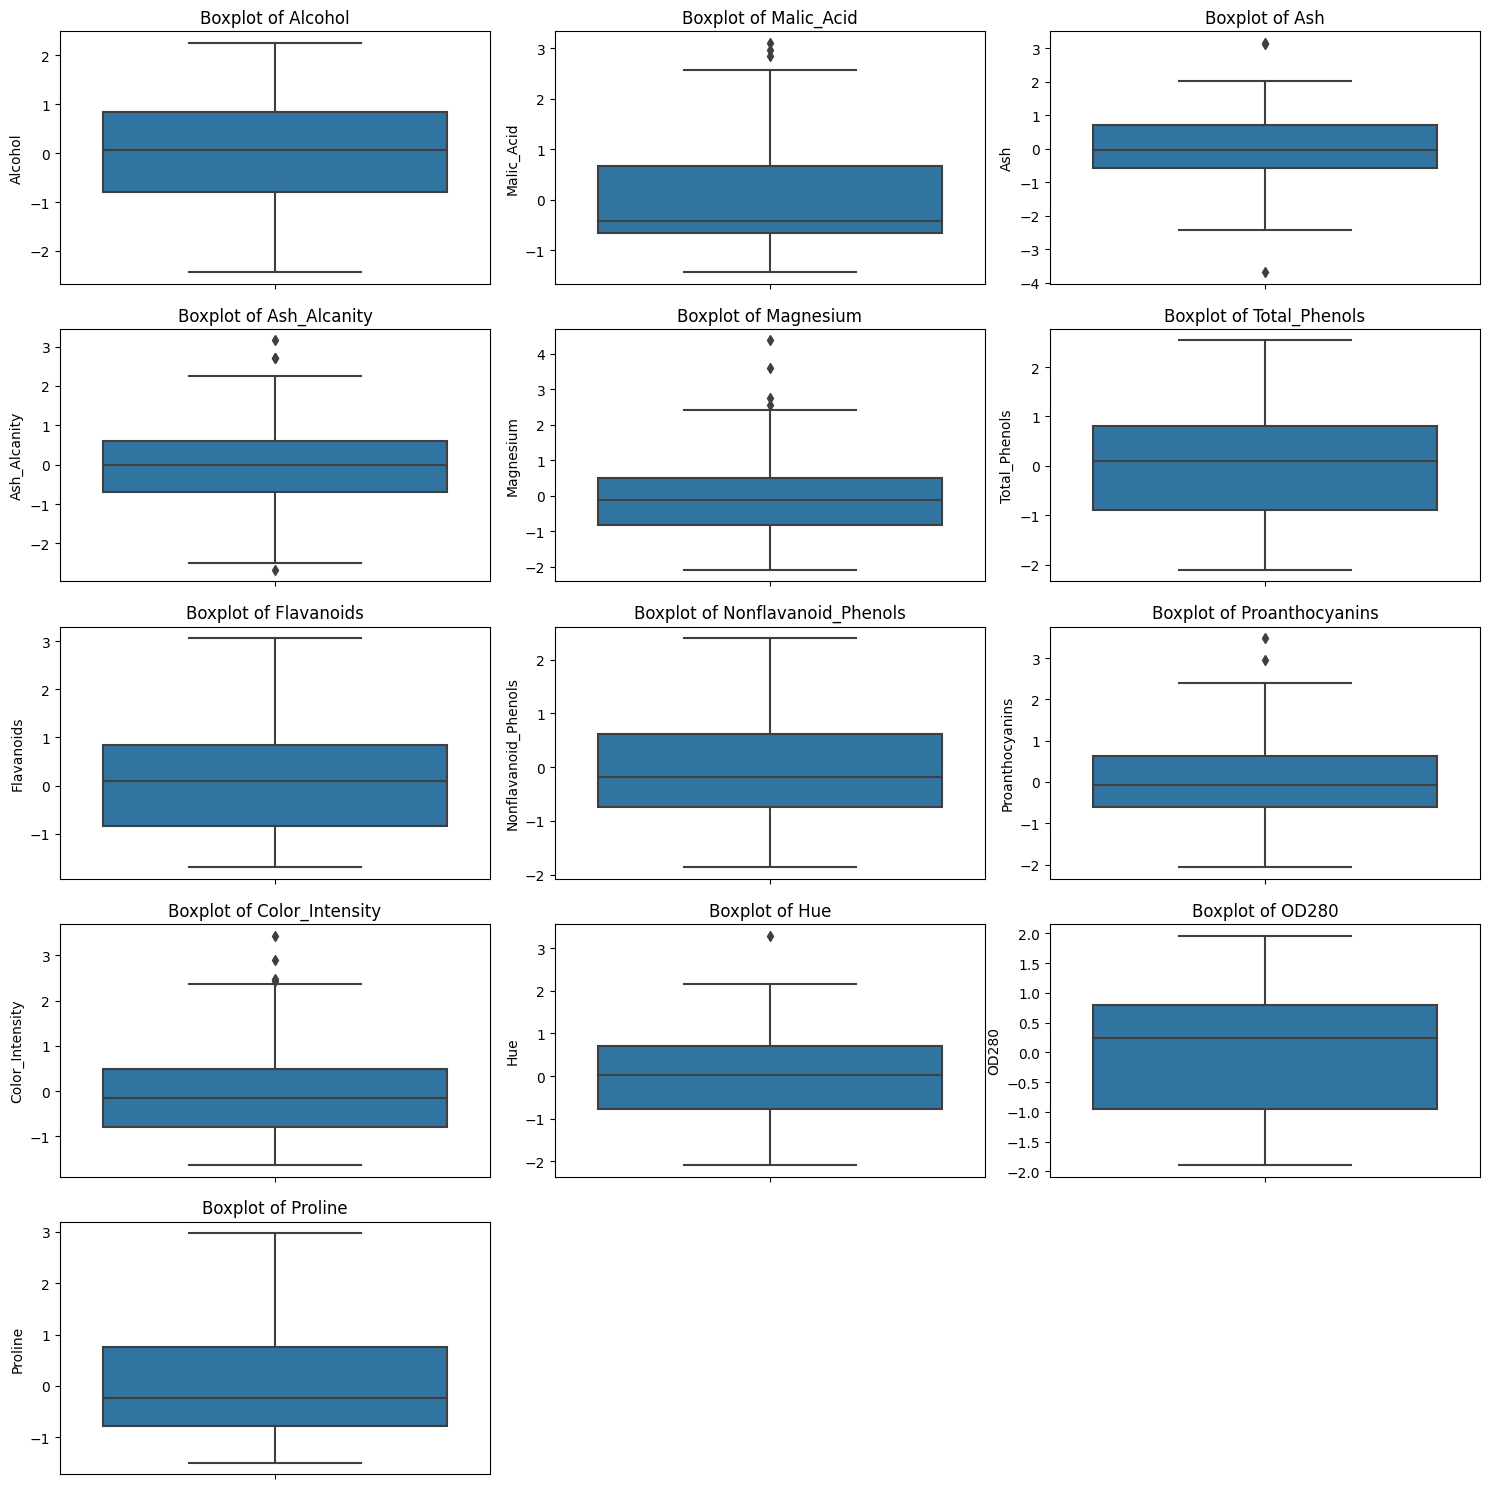

In [14]:
# Create box plots for each variable to visually inspect for outliers and distribution shapes
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the scaled data back to a DataFrame for plotting
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

# Set up the plot dimensions
num_columns = len(scaled_df.columns)
fig, axes = plt.subplots(nrows=(num_columns + 2) // 3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Generate box plots
for i, column in enumerate(scaled_df.columns):
    sns.boxplot(data=scaled_df, y=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

The box plots of the standardized variables reveal important insights related to PCA assumptions.

1) Presence of Outliers
    * Several variables show notable outliers. For example:
        * Malic_Acid, Proline, and Color_Intensity display significant high-end outliers.
        * Ash_Alcanity and OD280/OD315_of_Diluted_Wines also show moderate dispersion with some extremes.
    * While PCA is robust to mild outliers, heavy outliers may distort the principal components.
2) Distribution Shape:
    * Most variables are not perfectly symmetric, and some are moderately skewed.
    * PCA does not strictly require normality, but non-normal distributions combined with outliers can influence the direction and scale of components.

**Second Interpretation for PCA**
* The presence of outliers and mild skewness suggests that while PCA is applicable, its results should be interpreted with caution.
* If needed, robust PCA variants or outlier mitigation strategies (e.g., Winsorization or transformation) could be applied.

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

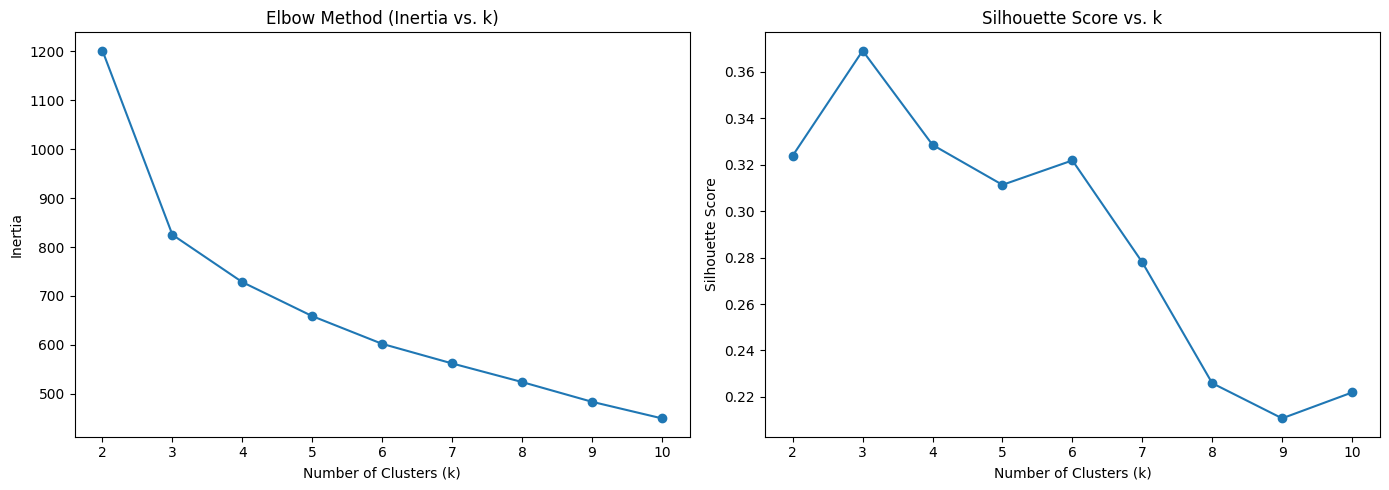

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different k values to determine the optimal number of clusters
k_values = range(2, 11)
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

# Plot inertia (elbow method) and silhouette score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_values, inertia, marker='o')
axes[0].set_title('Elbow Method (Inertia vs. k)')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')

# Silhouette score plot
axes[1].plot(k_values, silhouette_scores, marker='o')
axes[1].set_title('Silhouette Score vs. k')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

The plots shown above provide key insights for selecting the optimal number of clusters (k) for K-means clustering on the PCA-reduced wine data: 

1) Elbow Method (Inertia Plot)
   * The inertia (within-cluster sum of squares) decreases a k increases.
   * A noticeable "elbow" appears around k = 3 or 4, suggesting diminishing returns in reducing inertia beyond that point.
2) Silhouette Score Plot
   * The silhouette score peaks around k = 3, indicating well-separated and cohesive clusters at that value.
   * Beyond k = 3, the score decreases slightly, which suggests that increasing the number of clusters may lead to overlapping or less distinct clusters.

My interpretation is that, based on both the elbow and silhouette plots, k = 3 is a strong candidate for the number of clusters. This aligns with the original dataset's structure (which was derived from three wine types, although type labels were removed).

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


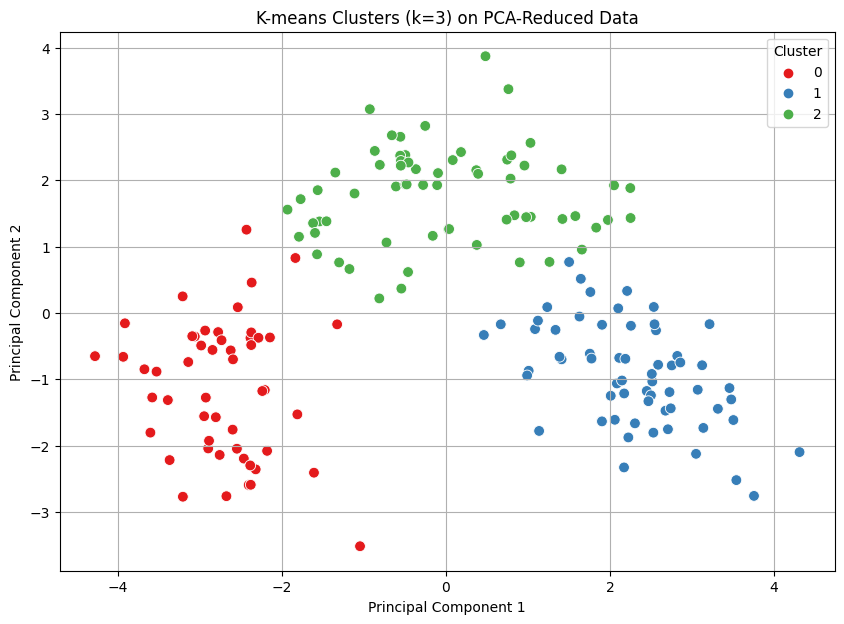

In [16]:
# Fit the final K-means model with k=3
final_kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = final_kmeans.fit_predict(pca_data)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
pca_df['Cluster'] = cluster_labels

# Scatter plot of the first two principal components colored by cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', s=60)
plt.title('K-means Clusters (k=3) on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

The scatterplot shown above displays the K-means clustering results with k = 3 using the first two principal components.

From my interpretation of the cluster visualization, three distinct clusters emerge, with good separation in the 2D PCA space. This supports the assumption that there are natural groupings within the wine data, which PCA has helped reveal. Furthermore, the shape and spread of each cluster suggest that PCA has effectively reduced dimensionality and preserved meaningful structure for clustering.

In [18]:
# Add cluster labels back to the original (unscaled) data for interpretation
original_df_with_clusters = df.copy()
original_df_with_clusters['Cluster'] = cluster_labels

# Calculate cluster centroids in the original feature space
cluster_centroids = original_df_with_clusters.groupby('Cluster').mean()

# Add size information for each cluster
cluster_sizes = original_df_with_clusters['Cluster'].value_counts().sort_index()
cluster_centroids['Cluster Size'] = cluster_sizes.values

# Display centroid values and sizes
cluster_centroids.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cluster Size
Cluster,,,,,,,,,,,,,,
0,13.134118,3.307255,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,7.234706,0.691961,1.696667,619.058824,51
1,13.676774,1.997903,2.466290,17.462903,107.967742,2.847581,3.003226,0.292097,1.922097,5.453548,1.065484,3.163387,1100.225806,62
2,12.250923,1.897385,2.231231,20.063077,92.738462,2.247692,2.050000,0.357692,1.624154,2.973077,1.062708,2.803385,510.169231,65


**Cluster Centroids and Composition Analysis (k = 3)**
Each row in the table represents the average values of each feature for a given cluster, along with the number of data points assigned to that cluster.

The following is a summary interpretation of the cluster profiles:

**Cluster 0**
* Size: 51 samples
* Key Characteristics:
    * Moderate alcohol and magnesium levels.
    * High malic acid and color intensity.
    * Lower flavonoid and OD280/OD315 levels.
* Interpretation: Possibly represents wines that are less aged or more acidic and less phenolic in nature.

**Cluster 1**
* Size: 62 samples (largest group)
* Key Characteristics:
    * Highest alcohol, phenols, flavonoids, and proline (an amino acid).
    * High OD280/OD315 (indicative of wine quality).
* Interpretation: Likely to be high-quality, full-bodied wines with strong flavor and aging potential.

**Cluster 2**
* Size: 65 samples
* Key Characteristics:
    * Lowest alcohol and magnesium.
    * Moderate phenols and flavonoids.
    * Lower color intensity and proline than Cluster 1.
* Interpretation: May represent lighter wines, potentially younger or made with less robust grape varieties.

Overall, the clusters reveal distinct wine profiles based on chemical composition. The PCA transformation, followed by K-means clustering, effectively grouped the wines in a way that suggests meaningful differentiation, likely aligning with underlying wine types or styles.

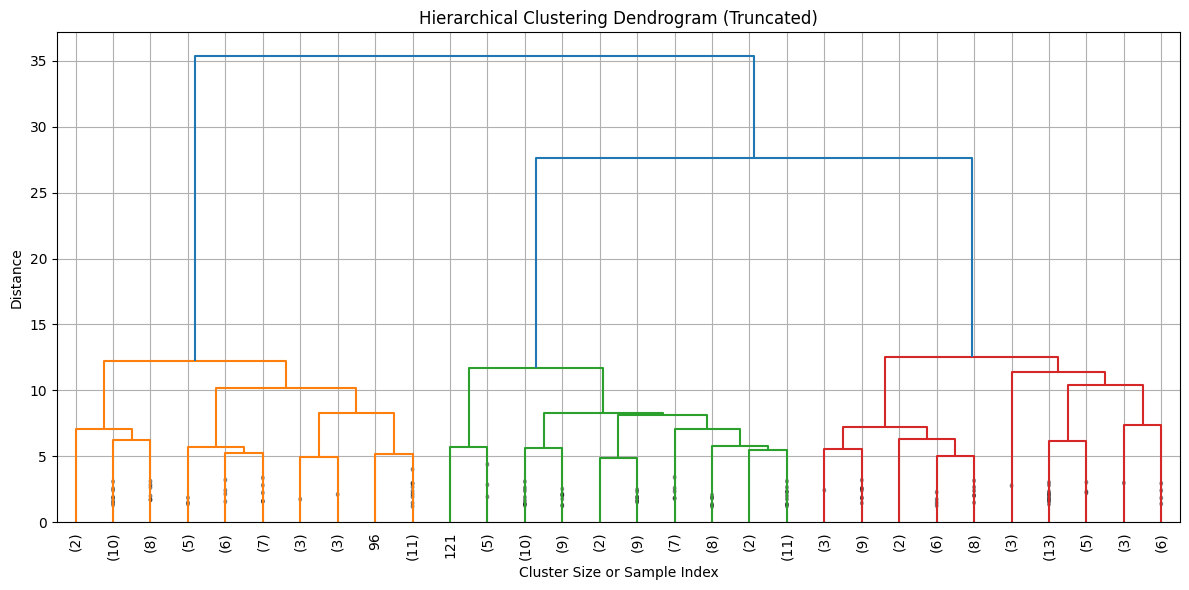

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Cluster Size
Hierarchical Cluster,,,,,,,,,,,,,,
1,13.061607,3.166607,2.412857,21.003571,99.857143,1.694286,0.847857,0.449464,1.129286,6.850179,0.721000,1.727321,624.946429,56
2,13.669219,1.970000,2.463125,17.528125,106.156250,2.850000,3.009688,0.291094,1.908125,5.450000,1.071406,3.158437,1076.046875,64
3,12.203966,1.938966,2.215172,20.208621,92.551724,2.262931,2.088103,0.355345,1.686552,2.895345,1.060000,2.862241,501.431034,58


In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# Compute the pairwise distance matrix
distance_matrix = pdist(scaled_data, metric='euclidean')

# Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(distance_matrix, method='ward')

# Create dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Size or Sample Index')
plt.ylabel('Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

# Cut the dendrogram at 3 clusters to match K-means
hierarchical_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')

# Add the hierarchical labels to the PCA dataframe
pca_df['Hierarchical Cluster'] = hierarchical_labels

# Compute cluster sizes
hierarchical_cluster_sizes = pd.Series(hierarchical_labels).value_counts().sort_index()

# Compute centroids for interpretation in original feature space
df_with_hier_clusters = df.copy()
df_with_hier_clusters['Hierarchical Cluster'] = hierarchical_labels
hierarchical_centroids = df_with_hier_clusters.groupby('Hierarchical Cluster').mean()
hierarchical_centroids['Cluster Size'] = hierarchical_cluster_sizes.values

hierarchical_centroids.head()

**Hierarchical Clustering Results and Interpretation**

Assumptions Check:
1) Distance Metric: I used Euclidean distance, which is suitable for continuous, standardized data.
2) Standardization: All features were standardized to ensure equal weighting -- this is critical as hierarchical clustering is sensitive to scale.
3) No Missing Data: The dataset is complete and properly preprocessed.
4) Outliers: As previously discussed via boxplots, a few outliers exist, but not enough to invalidate hierarchical clustering assumptions.

The dendrogram shows a clear separation into three large clusters at a relatively high linkage distance, supporting the choice of k = 3 as the K-means. Ward's linkage minimized within-cluster variance, leading to compact and interpretable clusters.

**Cluster Composition (Centroids)**

**Cluster 1**
* Size: 56
* Profile Summary: Similar to K-means Cluster 0: higher malic acid, moderate alcohol, high color intensity, low flavonoids. Possibly less mature or more acidic wines.

**Cluster 2**
* Size: 64
* Profile Summary: Matches K-means Cluster 1: high alcohol, phenols, flavonoids, and proline. Likely high-quality, full-bodied wines.

**Cluster 3**
* Size: 58
* Profile Summary: Similar to K-means Cluster 2: lowest alcohol and magnesium, moderate phenolics, lightest in color. Probably lighter or younger wines.

The results of hierarchical clustering closely align with K-means, validating the underlying natural grouping in the dataset. The cluster profiles are stable across methods, reinforcing the presence of three distinct wine styles or quality levels.

In [20]:
# Prepare side-by-side comparison
comparison_df = pd.DataFrame({
    'KMeans Cluster': cluster_labels,
    'Hierarchical Cluster': hierarchical_labels
})

# Count how many samples fall into each combination of KMeans and Hierarchical clusters
comparison_crosstab = pd.crosstab(comparison_df['KMeans Cluster'], comparison_df['Hierarchical Cluster'])

comparison_crosstab.head()

Hierarchical Cluster,1,2,3
KMeans Cluster,,,
0,51,0,0
1,0,61,1
2,5,3,57


**Side-by-Side Comparison of Cluster Assignments**
The contingency table shows how the K-means clusters (rows) align with the hierarchical clusters (columns): 

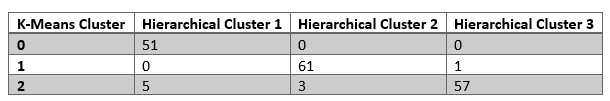 

In my observation, there is strong agreement when (1) K-Means Cluster 0 maps perfectly to Hierarchical Cluster 1, (2) when K-Means Cluster 1 maps almost entirely to Hierarchical Cluster 2, and (3) when K-Means Cluster 2 corresponds mostly to Hierarchical Cluster 3. Conversely, there are minor discrepancies when only a few data points (e.g., 5 in Cluster 2 to Cluster 1, 3 to Cluster 2) are assigned differently. 

In summary, there is very high consistency between K-means and hierarchical clustering, reinforcing the robustness of the three-cluster solution. This supports the conclusion that the dataset contains three well-defined groups, consistent across different unsupervised learning techniques.